In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [5]:
""" The following codes show how to get stock data from yfinance and then compute well known technical indicators:
I will periodically add more indicators.

*) RSI - Relative Strength Index.
*) MFI - Money Flow Index. 
*) MACD - Moving Average Convergence Divergence.
*) Aroon Indicators.
*) Average Directional Index.
*) Bollinger Bands. 
*) On-Balance Volume Indicator.
*) Stochastic Oscillator.
*) Williams % Range.
*) Percentage Price Oscillator.
*) Commodity Channel Index.
*) Average True Range.
*) Accumulation/Distribution. """

' The following codes show how to get stock data from yfinance and then compute well known technical indicators:\nI will periodically add more indicators.\n\n*) RSI - Relative Strength Index.\n*) MFI - Money Flow Index. \n*) MACD - Moving Average Convergence Divergence.\n*) Aroon Indicators.\n*) Average Directional Index.\n*) Bollinger Bands. \n*) On-Balance Volume Indicator.\n*) Stochastic Oscillator.\n*) Williams % Range.\n*) Percentage Price Oscillator.\n*) Commodity Channel Index.\n*) Average True Range. '

### Get Stock Data

In [31]:
#Instrument = 'JUN3.F' ### stock ticker
#Instrument = 'JEN.F'
Instrument = '4A3.F'

data = []
data = yf.download(Instrument, start='2024-01-01', end='2025-03-28', progress=False)
data = data[['Close','High','Low', 'Volume']] ### To compute RSI and MFI we only need these quantities

### Fill Forward -- Weekends and periods where the market ist not operating, for example weekends.
idx = pd.date_range(data.index[0], data.index[-1])
data = data.reindex(idx)
data.ffill(inplace=True)

data.head()

Price,Close,High,Low,Volume
Ticker,4A3.F,4A3.F,4A3.F,4A3.F
2024-01-02,9.74,9.74,9.44,350.0
2024-01-03,9.74,9.74,9.65,200.0
2024-01-04,9.26,9.26,9.26,0.0
2024-01-05,9.69,9.69,9.69,0.0
2024-01-06,9.69,9.69,9.69,0.0


### RSI - Relative Strength Index

In [7]:
### RSI - Relative Strength Index

### References
### https://wire.insiderfinance.io/calculate-rsi-with-python-and-yahoo-finance-c8fb78b1c199

window = 14 ### how many past days to consider in the exponentially weighted calculations.
adjust = False

delta = []
delta = data['Close'].diff(1) ### compute the price difference

loss = delta.copy()
gains = delta.copy()

gains[gains < 0] = 0
loss[loss > 0] = 0

gain_ewm = gains.ewm(com=window - 1, adjust=adjust).mean()
loss_ewm = abs(loss.ewm(com=window - 1, adjust=adjust).mean())

RS = []
RS = gain_ewm / loss_ewm

RSI = []
RSI = 100 - 100 / (1 + RS)
data['RSI'] = pd.DataFrame(RSI).rename(columns={"Close": "RSI"})

data.tail()

Price,Close,High,Low,Volume,RSI
Ticker,4A3.F,4A3.F,4A3.F,4A3.F,
2025-03-23,4.800,4.816,4.800,1100.0,57.566765
2025-03-24,4.562,4.562,4.562,0.0,50.298234
2025-03-25,4.690,4.690,4.602,500.0,53.685212
2025-03-26,4.160,4.302,4.160,500.0,41.173689
2025-03-27,4.600,4.600,4.170,1277.0,51.317280


### MFI - Money Flow Index

In [8]:
### References
### https://www.investopedia.com/terms/m/mfi.asp
### https://en.wikipedia.org/wiki/Money_flow_index

### Calculate the typical price and money flow

typical_price = []
typical_price  = data[['Close', 'High', 'Low']].sum(axis=1)/3 ### (Close + High + Low)/3

money_flow = []
money_flow = typical_price * data[data.columns[3]]

### For each period, mark whether the typical price was higher or lower than the prior period. 
### This will tell you whether raw money flow is positive or negative.

### Positive money flow is calculated by adding the money flow of all the 
### days where the typical price is higher than the previous day's typical price.

positive_flow = []
negative_flow = []

# Loop through the typical price
for i in range(0, len(typical_price)):

    if i == 0: ### money flow is not defined (there is no "previous typical price")
        positive_flow.append(0)
        negative_flow.append(0)

    else:
        if typical_price[i] > typical_price[i-1]:
            positive_flow.append(money_flow[i])
            negative_flow.append(0)

        elif typical_price[i] < typical_price[i-1]:
            negative_flow.append(money_flow[i])
            positive_flow.append(0)

        else:
            positive_flow.append(0)
            negative_flow.append(0)

positive_flow = pd.Series(positive_flow)
negative_flow = pd.Series(negative_flow)

# Get all of the positive and negative money flows within the time period

positive_mf = []
negative_mf = []

positive_mf = positive_flow.ewm(com=window - 1, adjust=adjust).mean()
negative_mf = negative_flow.ewm(com=window - 1, adjust=adjust).mean()

# Calculate the money flow index

MFI = []
MFI = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf) ))
MFI = pd.DataFrame(MFI, columns=['MFI'])
MFI.set_index([data.index],inplace=True)

data['MFI'] = MFI

data.head()

C:\Users\celes\AppData\Local\Temp\ipykernel_18860\1543970544.py:56: RuntimeWarning: invalid value encountered in divide
  MFI = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf) ))


Price,Close,High,Low,Volume,RSI,MFI
Ticker,4A3.F,4A3.F,4A3.F,4A3.F,,
2024-01-02,9.74,9.74,9.44,350.0,NaN,NaN
2024-01-03,9.74,9.74,9.65,200.0,NaN,100.0
2024-01-04,9.26,9.26,9.26,0.0,0.000000,100.0
2024-01-05,9.69,9.69,9.69,0.0,49.102759,100.0
2024-01-06,9.69,9.69,9.69,0.0,49.102759,100.0


### Plot Output RSI und MFI

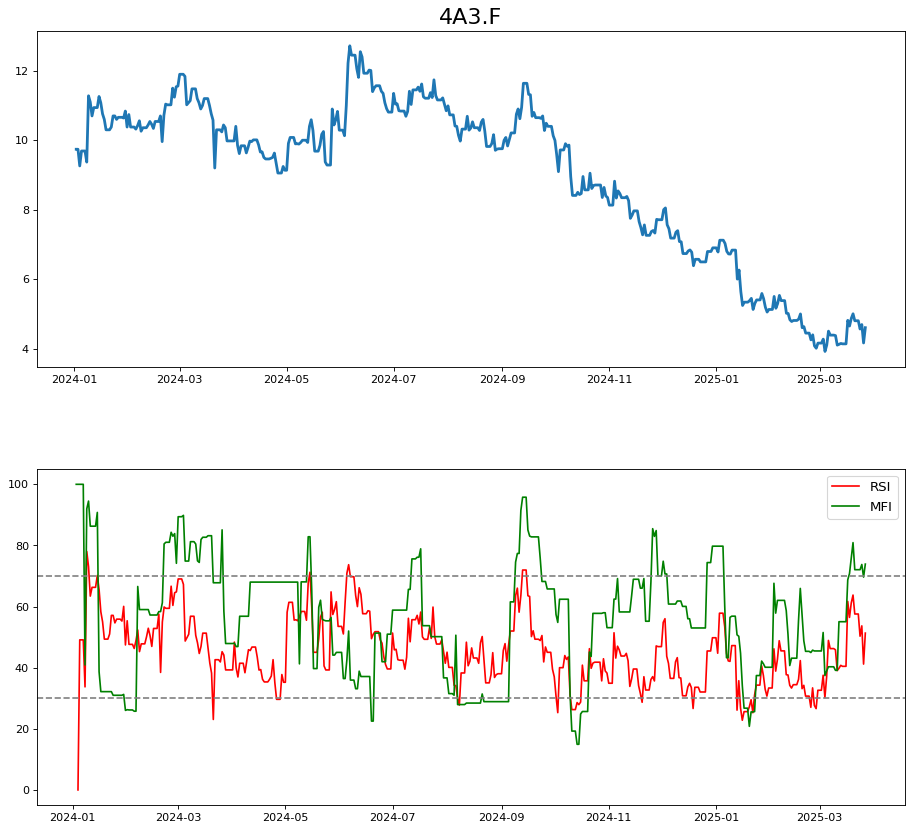

In [9]:
figure(figsize=(14, 14), dpi=80)

ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=4, colspan=1)
ax1.plot(data['Close'], linewidth=2.5)
ax1.set_title(Instrument, fontsize=20)
ax2.plot(data['RSI'], color='red', linewidth=1.5)
ax2.plot(data['MFI'], color='green', linewidth=1.5)
ax2.axhline(30, linestyle='--', linewidth=1.5, color='grey')
ax2.axhline(70, linestyle='--', linewidth=1.5, color='grey')
ax2.legend(['RSI', 'MFI'], fontsize=12)

plt.show()

 ## MACD - Moving Average Convergence Divergence

In [22]:
### References
### https://medium.com/@financial_python/building-a-macd-indicator-in-python-190b2a4c1777
### https://medium.com/@teopan00/macd-indicator-for-algorithmic-trading-in-python-ce2833993550

In [76]:
# Calculate the 12-period EMA
ema12 = []
ema12 = data['Close'].ewm(span=12, adjust=False).mean()

# Calculate the 26-period EMA
ema26 = []
ema26 = data['Close'].ewm(span=26, adjust=False).mean()

# Calculate MACD (the difference between 12-period EMA and 26-period EMA)
# Typically, widely-accepted values for the fast and slow lengths are 12 and 26, respectively. 
# The final values of the MACD line are determined by subtracting the EMA with the slow length from 
# the EMA with the fast length.

macd = []
macd = ema12 - ema26 ### fast - slow

# Calculate the 9-period EMA of MACD (Signal Line)
# The commonly used period for computing the Signal line is 9. 
# Since the Signal line averages out the MACD line, it tends to offer a smoother representation of trends.

signal_line = []
signal_line = macd.ewm(span=9, adjust=False).mean()

### Add MACD and Signal_line to dataframe

macd = pd.DataFrame(macd).rename(columns={"Close": "MACD"})
macd.set_index([data.index],inplace=True)

signal_line = pd.DataFrame(signal_line).rename(columns={"Close": "Signal_Line"})
signal_line.set_index([data.index],inplace=True)

# If MACD is above the signal line, the histogram will be above the MACD’s baseline or zero line. 
# If MACD is below its signal line, the histogram will be below the MACD’s baseline. 
# Traders use the MACD’s histogram to identify peaks of bullish or bearish momentum, 
# and to generate overbought/oversold trade signals.

data['MACD'] = macd
data['Signal_Line'] = signal_line

data.tail()

Price,Close,High,Low,Volume,OBV,%R,PPO,Signal_Line_PPO,MACD,Signal_Line
Ticker,JUN3.F,JUN3.F,JUN3.F,JUN3.F,JUN3.F,JUN3.F,JUN3.F,JUN3.F,,
2025-03-23,33.599998,33.599998,33.599998,0.0,5329.0,-59.778628,4.155915,5.343667,1.362097,1.711650
2025-03-24,33.880001,34.000000,33.880001,140.0,5469.0,-68.202741,3.776085,5.030150,1.240699,1.617460
2025-03-25,33.759998,33.759998,33.759998,0.0,5469.0,-71.962680,3.407503,4.705621,1.121875,1.518343
2025-03-26,33.919998,33.919998,33.919998,50.0,5519.0,-73.366892,3.117687,4.388034,1.028758,1.420426
2025-03-27,34.259998,35.060001,33.139999,451.0,5970.0,-79.629645,2.934943,4.097416,0.971202,1.330581


### Plot MACD

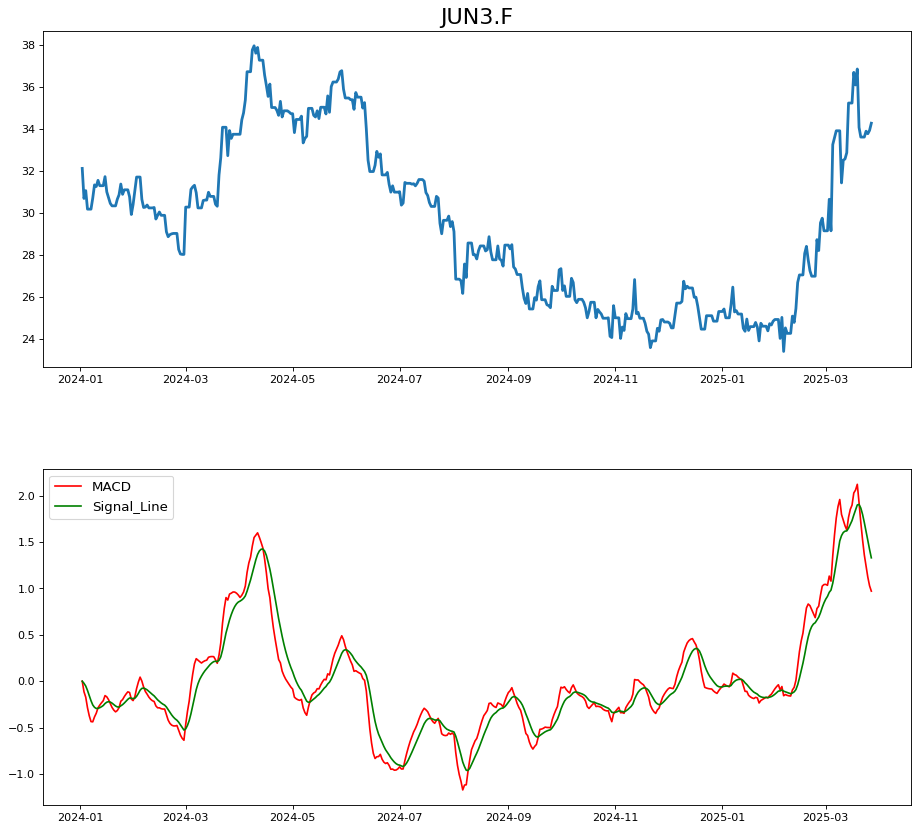

In [77]:
figure(figsize=(14, 14), dpi=80)

ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=4, colspan=1)
ax1.plot(data['Close'], linewidth=2.5)
ax1.set_title(Instrument, fontsize=20)
ax2.plot(data['MACD'], color='red', linewidth=1.5)
ax2.plot(data['Signal_Line'], color='green', linewidth=1.5)
#ax2.axhline(30, linestyle='--', linewidth=1.5, color='grey')
#ax2.axhline(70, linestyle='--', linewidth=1.5, color='grey')
ax2.legend(['MACD', 'Signal_Line'], fontsize=12)

plt.show()

### Aroon Indicators

In [31]:
### References
### https://medium.com/@jasperc09/a-complete-guide-implementing-aroon-indicators-using-python-1fe79e4bede6

In [11]:
period = 25 ### typical period

#Aroon Up and Down Formulas 
data['aroon_up'] = 100 * data.High.rolling(period).apply(lambda x: x.argmax()) / (period)
data['aroon_down'] = 100 * data.Low.rolling(period).apply(lambda x: x.argmin()) / (period)
data.head()

Price,Close,High,Low,Volume,RSI,MFI,MACD,Signal_Line,aroon_up,aroon_down
Ticker,4A3.F,4A3.F,4A3.F,4A3.F,,,,,,
2024-01-02,9.74,9.74,9.44,350.0,NaN,NaN,0.000000,0.000000,NaN,NaN
2024-01-03,9.74,9.74,9.65,200.0,NaN,100.0,0.000000,0.000000,NaN,NaN
2024-01-04,9.26,9.26,9.26,0.0,0.000000,100.0,-0.038291,-0.007658,NaN,NaN
2024-01-05,9.69,9.69,9.69,0.0,49.102759,100.0,-0.033552,-0.012837,NaN,NaN
2024-01-06,9.69,9.69,9.69,0.0,49.102759,100.0,-0.029457,-0.016161,NaN,NaN


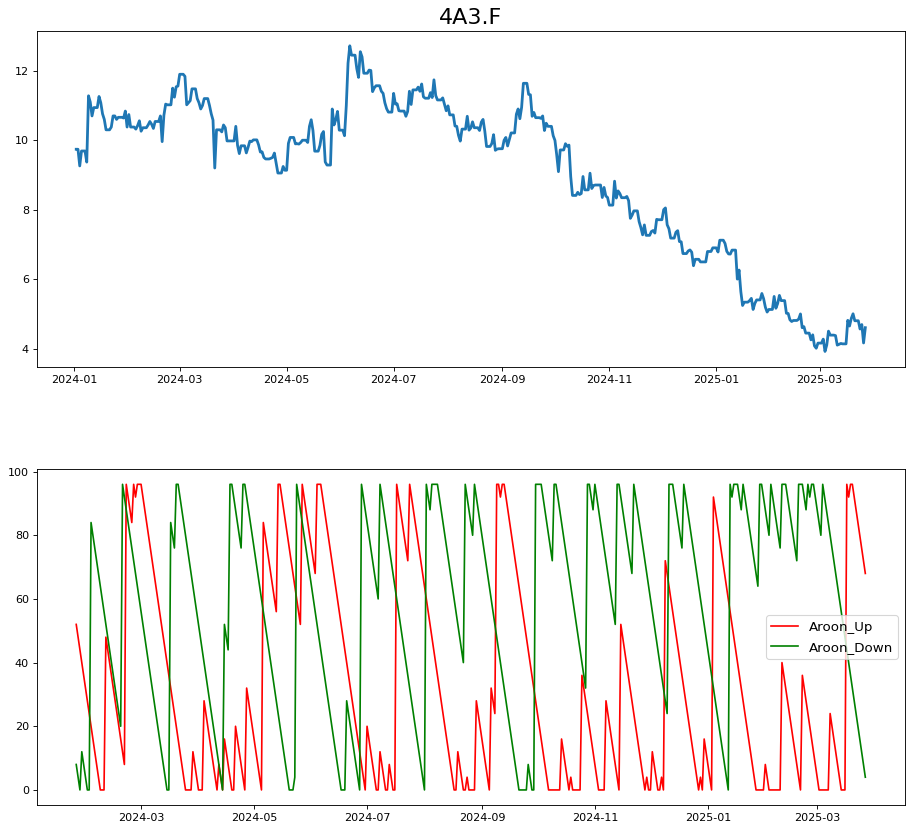

In [13]:
figure(figsize=(14, 14), dpi=80)

ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=4, colspan=1)
ax1.plot(data['Close'], linewidth=2.5)
ax1.set_title(Instrument, fontsize=20)
ax2.plot(data['aroon_up'], color='red', linewidth=1.5)
ax2.plot(data['aroon_down'], color='green', linewidth=1.5)
#ax2.axhline(30, linestyle='--', linewidth=1.5, color='grey')
#ax2.axhline(70, linestyle='--', linewidth=1.5, color='grey')
ax2.legend(['Aroon_Up', 'Aroon_Down'], fontsize=12)

plt.show()

### Average Directional Index

In [14]:
#### References
#### https://eodhd.medium.com/algorithmic-trading-with-the-average-directional-index-in-python-6f3b2ce08e75
#### https://www.investopedia.com/top-7-technical-analysis-tools-4773275

### ADX above 20 and DI+ above DI-. That's an uptrend.
### ADX above 20 and DI- above DI+. That's a downtrend.
### ADX below 20 is a weak trend or ranging period, often associated with the DI- and DI+ 
### rapidly crisscrossing each other.

In [15]:
period = 14

plus_dm = data.High.diff()
minus_dm = data.Low.diff()

plus_dm[plus_dm < 0] = 0
minus_dm[minus_dm > 0] = 0
    
tr1 = pd.DataFrame(data.High - data.Low)
tr2 = pd.DataFrame(abs(data.High - data.Close.shift(1)))
tr3 = pd.DataFrame(abs(data.Low - data.Close.shift(1)))

frames = [tr1, tr2, tr3]

tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
atr = tr.rolling(period).mean()
    
plus_di = 100 * (plus_dm.ewm(alpha = 1/period).mean() / atr)
minus_di = abs(100 * (minus_dm.ewm(alpha = 1/period).mean() / atr))
dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
adx = ((dx.shift(1) * (period - 1)) + dx) / period
adx_smooth = adx.ewm(alpha = 1/period).mean()

data['plus_di'] = pd.DataFrame(plus_di).rename(columns = {0:'plus_di'})
data['minus_di'] = pd.DataFrame(minus_di).rename(columns = {0:'minus_di'})
data['adx'] = pd.DataFrame(adx).rename(columns = {0:'adx'})

data.tail()

ValueError: Cannot set a DataFrame with multiple columns to the single column plus_di

KeyError: 'plus_di'

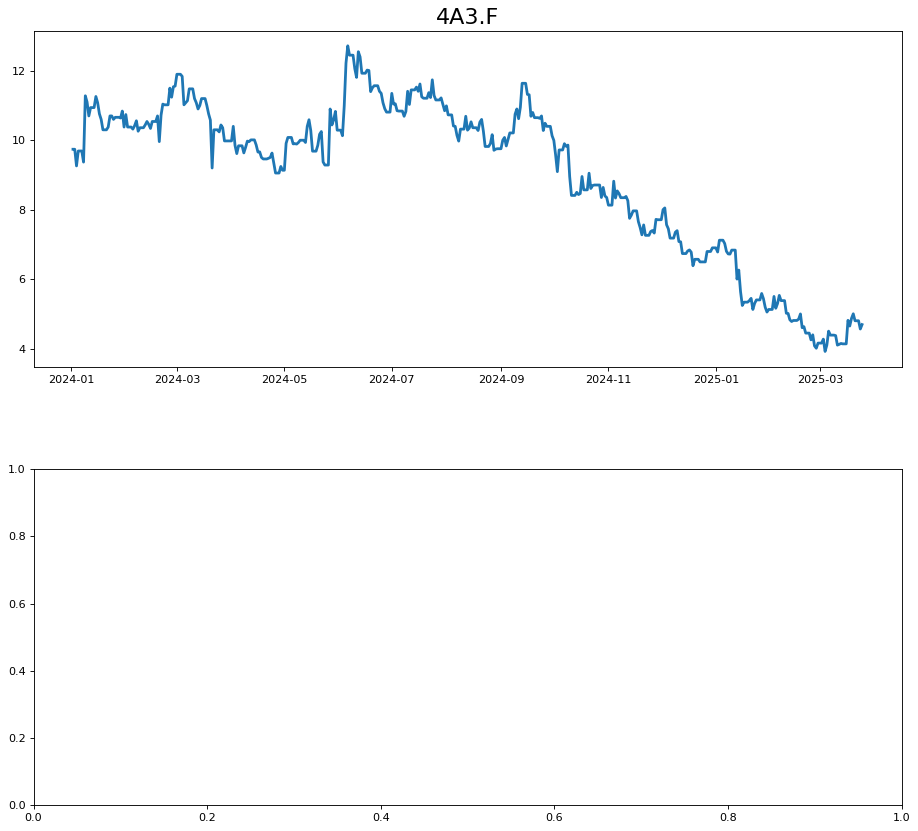

In [18]:
figure(figsize=(14, 14), dpi=80)

ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=4, colspan=1)
ax1.plot(data['Close'], linewidth=2.5)
ax1.set_title(ticker, fontsize=20)
ax2.plot(data['plus_di'], color='red', linewidth=1.5)
ax2.plot(data['minus_di'], color='green', linewidth=1.5)
ax2.plot(data['adx'], color='blue', linewidth=1.5)
ax2.axhline(20, linestyle='--', linewidth=1.5, color='grey')
#ax2.axhline(70, linestyle='--', linewidth=1.5, color='grey')
ax2.legend(['plus_di', 'minus_di', 'adx'], fontsize=12)

plt.show()

### Bollinger Bands

In [ ]:
### Ref https://medium.com/@financial_python/how-to-plot-bollinger-bands-in-python-1d7cc95ad9af

In [29]:
# Calculate the 20-period Simple Moving Average (SMA)
data[('SMA',Instrument)] = data[data.columns[0]].rolling(window=20).mean()

# Calculate the 20-period Standard Deviation (SD)
data[('SD',Instrument)] = data[data.columns[0]].rolling(window=20).std()

# Calculate the Upper Bollinger Band (UB) and Lower Bollinger Band (LB)
data[('UB',Instrument)] = data[('SMA',Instrument)] + 2 * data[('SD',Instrument)]
data[('LB',Instrument)] = data[('SMA',Instrument)] - 2 * data[('SD',Instrument)]

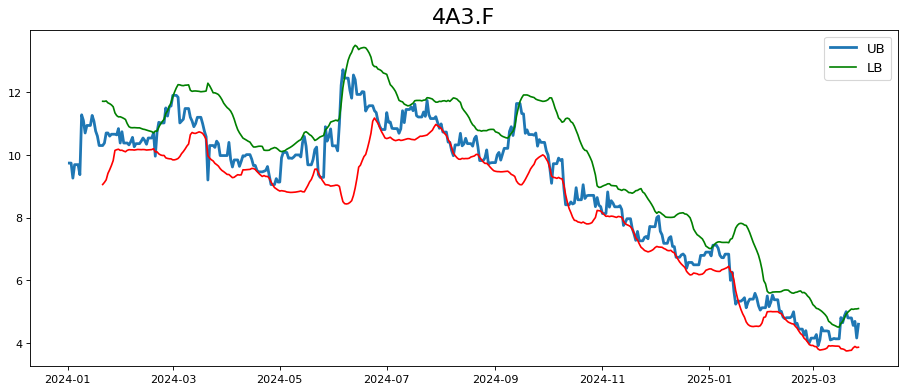

In [17]:
figure(figsize=(14, 14), dpi=80)

ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
#ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=4, colspan=1)
ax1.plot(data[('Close', Instrument)], linewidth=2.5)
ax1.set_title(Instrument, fontsize=20)
ax1.plot(data[('UB',Instrument)], color='green', linewidth=1.5)
ax1.plot(data[('LB',Instrument)], color='red', linewidth=1.5)
#ax1.axhline(20, linestyle='--', linewidth=1.5, color='grey')
#ax2.axhline(70, linestyle='--', linewidth=1.5, color='grey')
ax1.legend(['UB', 'LB'], fontsize=12)

plt.show()

### On-Balance Volume Indicator

In [60]:
### Ref https://medium.com/@mburakbedir/uncover-hidden-market-trends-with-the-on-balance-volume-obv-indicator-and-python-6aa194aa4a05

def calculate_obv(data):
    obv = [0]
    for i in range(1, len(data)):
        if data[('Close',Instrument)][i] > data[('Close',Instrument)][i-1]:
            obv.append(obv[-1] + data[('Volume', Instrument)][i])
        elif data[('Close',Instrument)][i] < data[('Close',Instrument)][i-1]:
            obv.append(obv[-1] - data[('Volume', Instrument)][i])
        else:
            obv.append(obv[-1])
    return obv

data[('OBV', Instrument)] = calculate_obv(data)
    
data.head()

Price,Close,High,Low,Volume,A/D,OBV
Ticker,4A3.F,4A3.F,4A3.F,4A3.F,4A3.F,4A3.F
2024-01-02,9.74,9.74,9.44,350.0,350.0,0.0
2024-01-03,9.74,9.74,9.65,200.0,550.0,0.0
2024-01-04,9.26,9.26,9.26,0.0,550.0,0.0
2024-01-05,9.69,9.69,9.69,0.0,550.0,0.0
2024-01-06,9.69,9.69,9.69,0.0,550.0,0.0


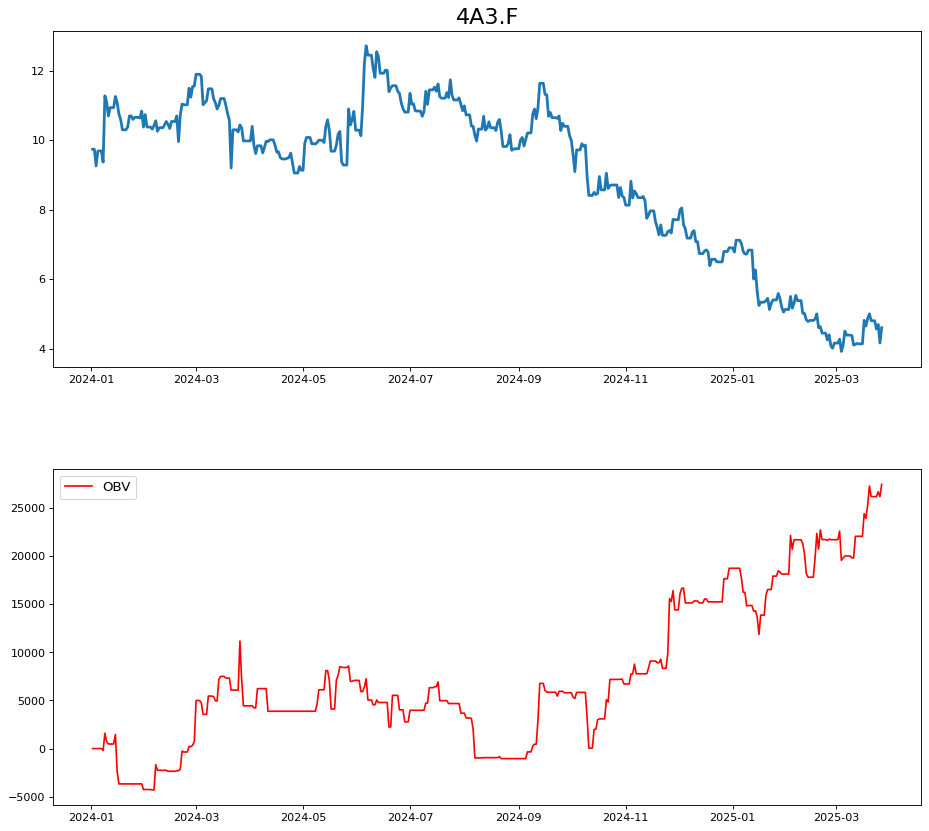

In [61]:
figure(figsize=(14, 14), dpi=80)

ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=4, colspan=1)
ax1.plot(data[('Close',Instrument)], linewidth=2.5)
ax1.set_title(Instrument, fontsize=20)
ax2.plot(data[('OBV', Instrument)], color='red', linewidth=1.5)
ax2.legend(['OBV'], fontsize=12)

plt.show()

### Stochastic Oscillator

In [ ]:
### Script needs corrections!!

In [23]:
### Ref https://rbdundas.medium.com/calculate-stochastic-oscillator-in-python-and-pandas-and-chart-with-matplotlib-aafde26b4a1f

def get_stochastic_oscillator(data, period=14):
    for i in range(len(data)):
        low = data.iloc[i][('Close',Instrument)]
        high = data.iloc[i][('Close',Instrument)]
        if i >= period:
            n = 0
            while n < period:
                if data.iloc[i-n][('Close',Instrument)] >= high:
                    high = data.iloc[i-n][('Close',Instrument)]
                elif data.iloc[i-n][('Close',Instrument)] < low:
                    low = data.iloc[i-n][('Close',Instrument)]
                n += 1
            data.at[i, ('best_low', Instrument)] = low
            data.at[i, ('best_high',Instrument)] = high
            data.at[i, ('fast_k',Instrument)] = 100*((data.iloc[i][('Close',Instrument)]-data.iloc[i][('best_low', Instrument)])/(data.iloc[i][('best_high',Instrument)]-data.iloc[i][('best_low', Instrument)]))

    data[('fast_d',Instrument)] = data[('fast_k',Instrument)].rolling(3).mean().round(2)
    data[('slow_k',Instrument)] = data[('fast_d',Instrument)]
    data[('slow_d',Instrument)] = data[('slow_k',Instrument)].rolling(3).mean().round(2)

    return data

get_stochastic_oscillator(data, period=14)

data.head()

Price,Close,High,Low,Volume,best_low,best_high,fast_k,fast_d,slow_k,slow_d
Ticker,4A3.F,4A3.F,4A3.F,4A3.F,4A3.F,4A3.F,4A3.F,4A3.F,4A3.F,4A3.F
2024-01-02 00:00:00,9.74,9.74,9.44,350.0,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-03 00:00:00,9.74,9.74,9.65,200.0,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-04 00:00:00,9.26,9.26,9.26,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-05 00:00:00,9.69,9.69,9.69,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-06 00:00:00,9.69,9.69,9.69,0.0,NaN,NaN,NaN,NaN,NaN,NaN


### Williams % Range

In [71]:
### Ref https://trendspider.com/learning-center/introduction-to-williams-r-range/

def calculate_wr(data, Instrument, period = 14):
    
    wr = []
    for i in range(data.shape[0]):

        ### Determine the highest high and lowest low over the look-back period (usually 14 periods).

        highest_high = []
        highest_high = data[('Close', Instrument)].iloc[i - period+1: i+1].max()

        lowest_low = []
        lowest_low = data[('Close', Instrument)].iloc[i - period+1: i+1].min()

        closing_price = []
        closing_price = data[('Close', Instrument)].iloc[i]

        wr.append(-100 * (highest_high - closing_price) / (highest_high - lowest_low))

    data[('%R', Instrument)] = wr
    
calculate_wr(data, Instrument, period = 14)

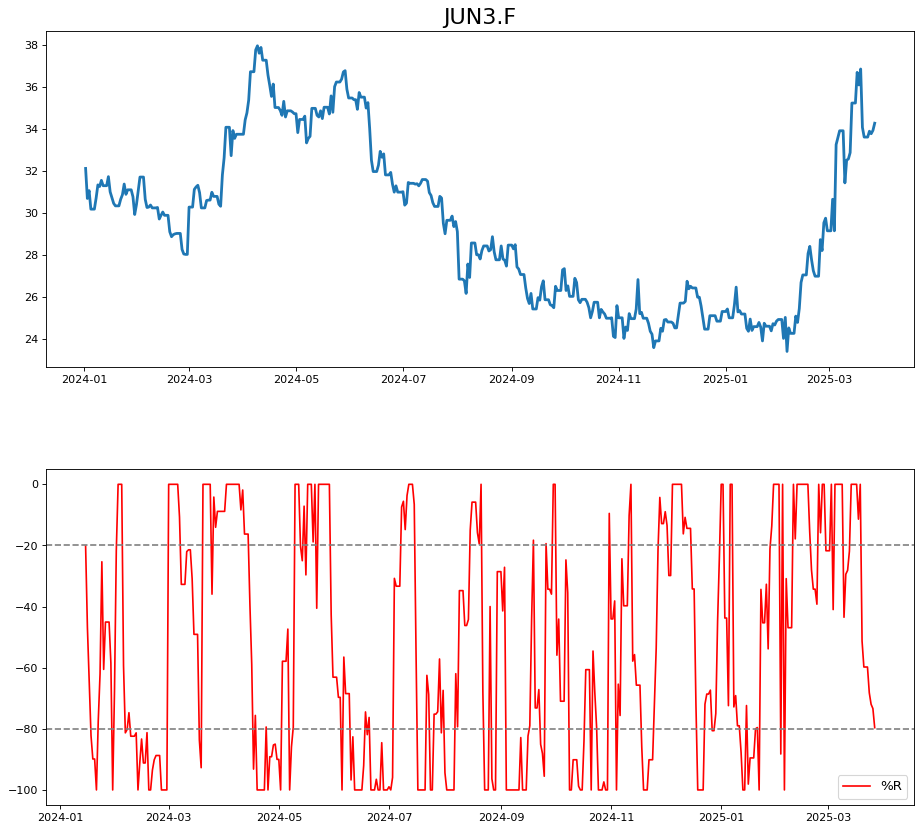

In [72]:
figure(figsize=(14, 14), dpi=80)

ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=4, colspan=1)
ax1.plot(data[('Close',Instrument)], linewidth=2.5)
ax1.set_title(Instrument, fontsize=20)
ax2.plot(data[('%R', Instrument)], color='red', linewidth=1.5)
ax2.legend(['%R'], fontsize=12)
ax2.axhline(-20, linestyle='--', linewidth=1.5, color='grey')
ax2.axhline(-80, linestyle='--', linewidth=1.5, color='grey')

plt.show()

### Percentage Price Oscillator

In [73]:
### Ref https://dataqoil.com/2022/03/20/python-for-stock-market-analysis-exploring-technical-trend-indicators/

### Very much like MACD but with percentages. 
### I will keep only one of those.

def ppo(data, Instrument):
    
    # Calculate the 12-period EMA
    ema12 = []
    ema12 = data['Close'].ewm(span=12, adjust=False).mean()

    # Calculate the 26-period EMA
    ema26 = []
    ema26 = data['Close'].ewm(span=26, adjust=False).mean()

    ### PPO
    ppo = []
    ppo = 100*(ema12 - ema26)/ema26
    
    ### Signal Line
    signal_line_ppo = []
    singal_line_ppo = ppo.ewm(span=9, adjust=False).mean()

    data[('PPO', Instrument)] = ppo
    data[('Signal_Line_PPO', Instrument)] = singal_line_ppo

ppo(data,Instrument)

data.head(2)

Price,Close,High,Low,Volume,OBV,%R,PPO,Signal_Line_PPO
Ticker,JUN3.F,JUN3.F,JUN3.F,JUN3.F,JUN3.F,JUN3.F,JUN3.F,JUN3.F
2024-01-02,32.108986,32.715923,32.108986,60.0,0.0,NaN,0.000000,0.000000
2024-01-03,30.679747,32.539720,30.660168,459.0,-459.0,NaN,-0.356257,-0.071251


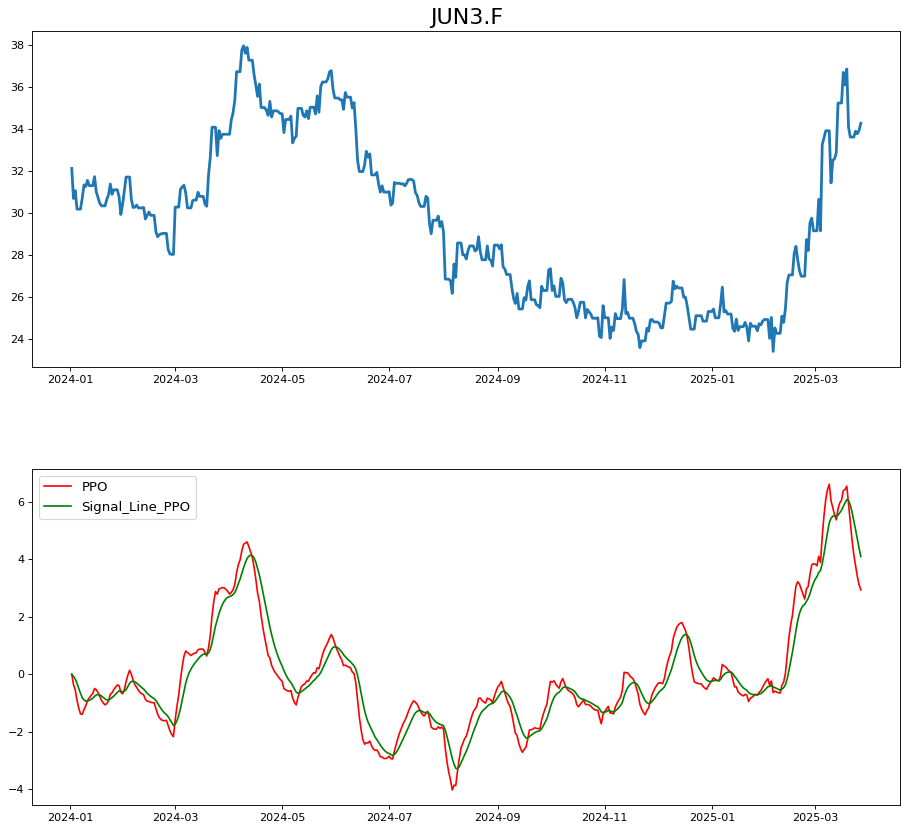

In [75]:
figure(figsize=(14, 14), dpi=80)

ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=4, colspan=1)
ax1.plot(data[('Close', Instrument)], linewidth=2.5)
ax1.set_title(Instrument, fontsize=20)
ax2.plot(data[('PPO',Instrument)], color='red', linewidth=1.5)
ax2.plot(data[('Signal_Line_PPO', Instrument)], color='green', linewidth=1.5)
#ax2.axhline(30, linestyle='--', linewidth=1.5, color='grey')
#ax2.axhline(70, linestyle='--', linewidth=1.5, color='grey')
ax2.legend(['PPO', 'Signal_Line_PPO'], fontsize=12)

plt.show()

### Commodity Channel Index

In [10]:
### Ref https://medium.com/@huzaifazahoor654/how-to-calculate-cci-in-python-a-step-by-step-guide-9a3f61698be6

import pandas as pd
import numpy as np

def calculate_cci(data, Instrument, period=20):
    
    TP = (data[('High', Instrument)] + data[('Low', Instrument)] + data[('Close', Instrument)]) / 3
    
    SMA = TP.rolling(window=period).mean()
    
    mad = TP.rolling(window=period).apply(
        lambda x: np.mean(np.abs(x - np.mean(x))), raw=True
    )
    
    CCI = (TP - SMA) / (0.015 * mad)
    
    data[('CCI', Instrument)] = CCI
    
calculate_cci(data, Instrument)

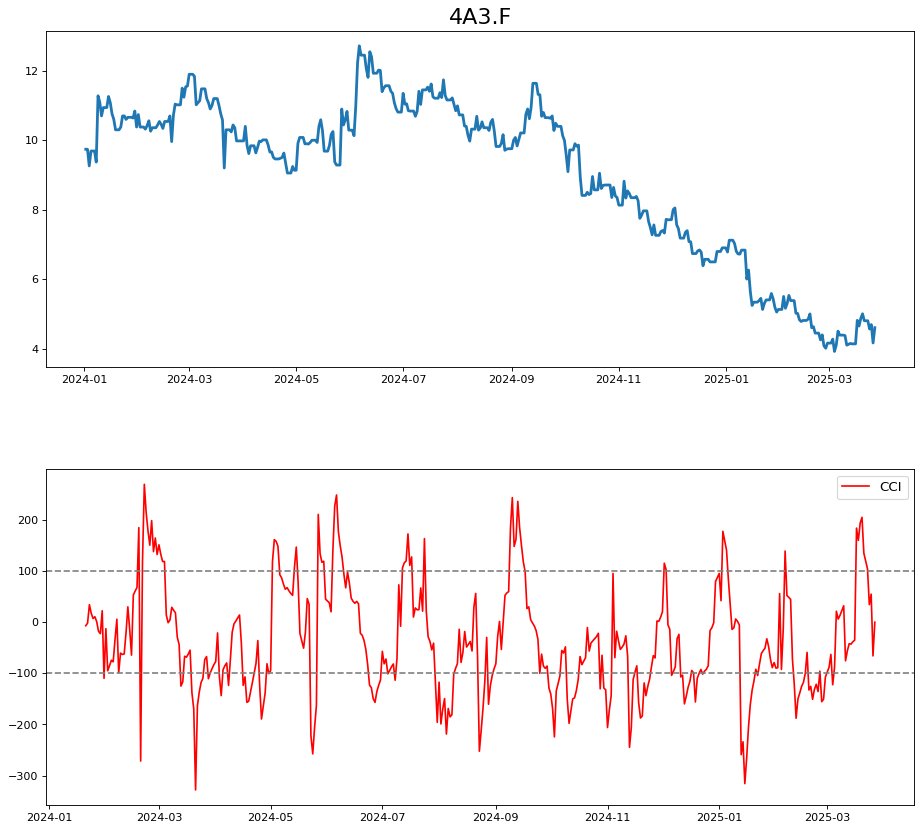

In [11]:
figure(figsize=(14, 14), dpi=80)

ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=4, colspan=1)
ax1.plot(data[('Close', Instrument)], linewidth=2.5)
ax1.set_title(Instrument, fontsize=20)
ax2.plot(data[('CCI',Instrument)], color='red', linewidth=1.5)
ax2.axhline(100, linestyle='--', linewidth=1.5, color='grey')
ax2.axhline(-100, linestyle='--', linewidth=1.5, color='grey')
ax2.legend(['CCI'], fontsize=12)

plt.show()

### Average True Range

In [12]:
### Ref https://medium.com/@huzaifazahoor654/how-to-calculate-cci-in-python-a-step-by-step-guide-9a3f61698be6

import pandas as pd

def calculate_true_range(data, Instrument):
    data[('high_low',Instrument)] = data[('High',Instrument)] - data[('Low',Instrument)]
    data[('high_prev_close', Instrument)] = abs(data[('High',Instrument)] - data[('Close',Instrument)].shift(1))
    data[('low_prev_close', Instrument)] = abs(data[('Low',Instrument)] - data[('Close',Instrument)].shift(1))
    
    data[('True_Range',Instrument)] = data[[('high_low',Instrument), ('high_prev_close',Instrument), ('low_prev_close',Instrument)]].max(axis=1)

    data.drop([('high_low',Instrument), ('high_prev_close', Instrument),('low_prev_close', Instrument)], axis=1, inplace=True)
    
def calculate_atr(data, Instrument, period=14, atr_type='rma'):
        
    if atr_type == 'rma':
        data[('ATR',Instrument)] = data[('True_Range',Instrument)].ewm(alpha=1/period, adjust=False).mean()
    elif atr_type == 'sma':
        data[('ATR',Instrument)] = data[('True_Range',Instrument)].rolling(window=period).mean()
    elif atr_type == 'ema':
        data[('ATR',Instrument)] = data[('True_Range',Instrument)].ewm(span=period, adjust=False).mean()
    elif atr_type == 'wma':
        weights = pd.Series(range(1, period + 1))
        data[('ATR',Instrument)] = data[('True_Range',Instrument)].rolling(window=period).apply(lambda x: (weights*x).sum() / weights.sum(), raw=True)
    else:
        raise ValueError(f"Unknown ATR type: {atr_type}")
    
    data.drop([('True_Range',Instrument)], axis=1, inplace=True)


calculate_true_range(data, Instrument)
calculate_atr(data, Instrument, period=14, atr_type='rma')

data.head()

Price,Close,High,Low,Volume,RSI,MFI,CCI,ATR
Ticker,4A3.F,4A3.F,4A3.F,4A3.F,,,4A3.F,4A3.F
2024-01-02,9.74,9.74,9.44,350.0,NaN,NaN,NaN,0.300000
2024-01-03,9.74,9.74,9.65,200.0,NaN,100.0,NaN,0.285000
2024-01-04,9.26,9.26,9.26,0.0,0.000000,100.0,NaN,0.298929
2024-01-05,9.69,9.69,9.69,0.0,49.102759,100.0,NaN,0.308291
2024-01-06,9.69,9.69,9.69,0.0,49.102759,100.0,NaN,0.286270


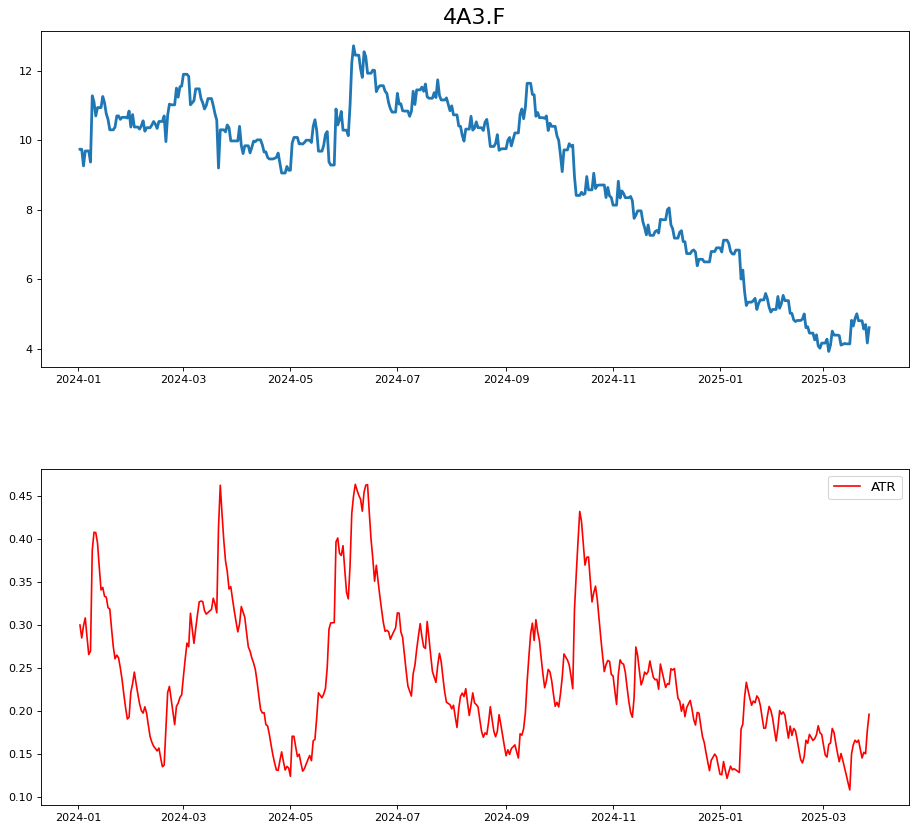

In [13]:
figure(figsize=(14, 14), dpi=80)

ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=4, colspan=1)
ax1.plot(data[('Close', Instrument)], linewidth=2.5)
ax1.set_title(Instrument, fontsize=20)
ax2.plot(data[('ATR',Instrument)], color='red', linewidth=1.5)
#ax2.axhline(100, linestyle='--', linewidth=1.5, color='grey')
#ax2.axhline(-100, linestyle='--', linewidth=1.5, color='grey')
ax2.legend(['ATR'], fontsize=12)

plt.show()   

### Accumulation/Distribution 

In [58]:
### Ref https://www.investopedia.com/terms/a/accumulationdistribution.asp

def Accumulation_distribution(data, Instrument):
    
    MFMc = []
    MFMc = (data[('Close',Instrument)]-data[('Low', Instrument)]) 
    
    MFMh = [] 
    MFMh = (data[('High', Instrument)]-data[('Close',Instrument)])
    
    MFMhl = []
    MFMhl = (data[('High', Instrument)]-data[('Low',Instrument)])
    
    ### Money Flow Multiplier
    
    MFM = []
    for i in range(0, len(MFMc)):
        value = []
        value = MFMc.iloc[i] - MFMh.iloc[i]
        if value == 0:
            MFM.append(value) ### avoid to divide by zero
        else:
            value = []
            value = (MFMc.iloc[i] - MFMh.iloc[i])/MFMhl[i]
            MFM.append(value)
    
    ### Money Flow Volume
    MFV = []
    MFV = MFM * data[('Volume', Instrument)]
       
    ad = []
    for i in range(0,len(MFV)):
        if i==0:
            ad.append(MFV[i])
        else:
            ad.append(ad[-1]+MFV[i])
            
    data[('A/D', Instrument)] = ad
    
Accumulation_distribution(data, Instrument)

In [ ]:
figure(figsize=(14, 14), dpi=80)

ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=4, colspan=1)
ax1.plot(data[('Close', Instrument)], linewidth=2.5)
ax1.set_title(Instrument, fontsize=20)
ax2.plot(data[('A/D',Instrument)], color='red', linewidth=1.5)
#ax2.axhline(100, linestyle='--', linewidth=1.5, color='grey')
#ax2.axhline(-100, linestyle='--', linewidth=1.5, color='grey')
ax2.legend(['A/D'], fontsize=12)

plt.show() 

###  Fibonacci Retracement Levels

In [32]:
### Ref https://www.investopedia.com/terms/f/fibonacciretracement.asp
### Need to think, to compute "local levels", compute levels using windows of interest.

def fibo_retracement_levels(data, Instrument, period = 30):
    
    price_range = []
    price_range = data[('Close', Instrument)].rolling(period).max() - data[('Close', Instrument)].rolling(period).min()
    
    data[("level1", Instrument)] =  data[('Close', Instrument)].rolling(period).max() - 0.236 * price_range
    data[("level2", Instrument)] =  data[('Close', Instrument)].rolling(period).max() - 0.382 * price_range
    data[("level3", Instrument)] =  data[('Close', Instrument)].rolling(period).max() - 0.618 * price_range
    
fibo_retracement_levels(data, Instrument, period = 30)

data.head(2)

Price,Close,High,Low,Volume,level1,level2,level3
Ticker,4A3.F,4A3.F,4A3.F,4A3.F,4A3.F,4A3.F,4A3.F
2024-01-02,9.74,9.74,9.44,350.0,NaN,NaN,NaN
2024-01-03,9.74,9.74,9.65,200.0,NaN,NaN,NaN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


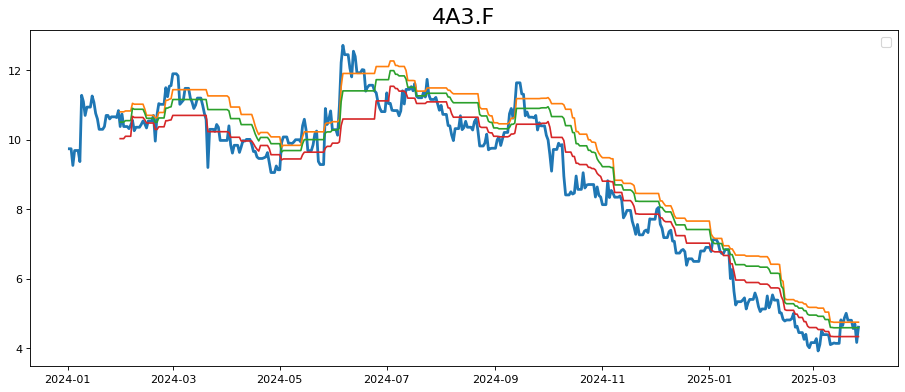

In [33]:
figure(figsize=(14, 14), dpi=80)

ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
ax1.plot(data[('Close', Instrument)], linewidth=2.5)
ax1.set_title(Instrument, fontsize=20)
ax1.plot(data[('level1',Instrument)], linewidth=1.5)
ax1.plot(data[('level2',Instrument)], linewidth=1.5)
ax1.plot(data[('level3',Instrument)], linewidth=1.5)
ax1.legend(fontsize=12)

plt.show() 

### Ichimoku Cloud

In [16]:
### Ref https://medium.com/@aaron_delarosa/implementing-ichimoku-trading-strategy-using-python-98641418312b

def Ichimoku_cloud(data, Instrument):

    # Tenkan-sen (Conversion Line): (9-period high + 9-period low)/2))
    nine_period_high = []
    nine_period_high = data[('High',Instrument)].rolling(window= 9).max()
    
    nine_period_low = []
    nine_period_low = data[('Low',Instrument)].rolling(window= 9).min()
    
    data[('tenkan_sen',Instrument)] = (nine_period_high + nine_period_low) /2
    
    # Kijun-sen (Base Line): (26-period high + 26-period low)/2))
    period26_high = []
    period26_high = data[('High',Instrument)].rolling(window=26).max()
    
    period26_low = []
    period26_low = data[('Low',Instrument)].rolling(window=26).min()
    
    data[('kijun_sen',Instrument)] = (period26_high + period26_low) / 2
    
    # Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
    data[('senkou_span_a',Instrument)] = ((data[('tenkan_sen',Instrument)] + data[('kijun_sen',Instrument)]) / 2).shift(26)
    
    # Senkou Span B (Leading Span B): (52-period high + 52-period low)/2))
    period52_high = []
    period52_high = data[('High',Instrument)].rolling(window=52).max()
    
    period52_low = []
    period52_low = data[('Low',Instrument)].rolling(window=52).min()
    
    data[('senkou_span_b',Instrument)] = ((period52_high + period52_low) / 2).shift(26)
    
    # The most current closing price plotted 26 time periods behind (optional)
    data[('chikou_span',Instrument)] = data[('Close',Instrument)].shift(-26)
    
Ichimoku_cloud(data, Instrument)

data.head()

Price,Close,High,Low,Volume,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,chikou_span
Ticker,4A3.F,4A3.F,4A3.F,4A3.F,4A3.F,4A3.F,4A3.F,4A3.F,4A3.F
2024-01-02,9.74,9.74,9.44,350.0,NaN,NaN,NaN,NaN,10.66
2024-01-03,9.74,9.74,9.65,200.0,NaN,NaN,NaN,NaN,10.64
2024-01-04,9.26,9.26,9.26,0.0,NaN,NaN,NaN,NaN,10.84
2024-01-05,9.69,9.69,9.69,0.0,NaN,NaN,NaN,NaN,10.38
2024-01-06,9.69,9.69,9.69,0.0,NaN,NaN,NaN,NaN,10.74


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


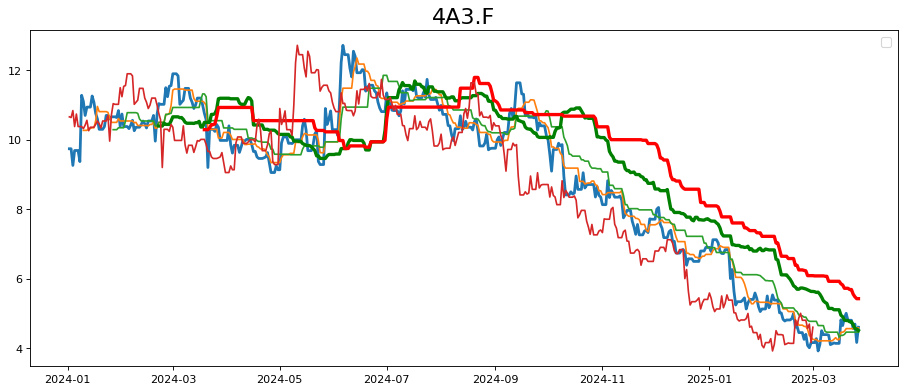

In [17]:
figure(figsize=(14, 14), dpi=80)

ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
ax1.plot(data[('Close', Instrument)], linewidth=2.5)
ax1.set_title(Instrument, fontsize=20)
ax1.plot(data[('tenkan_sen',Instrument)], linewidth=1.5)
ax1.plot(data[('kijun_sen',Instrument)], linewidth=1.5)
ax1.plot(data[('senkou_span_a',Instrument)], color='green', linewidth=3)
ax1.plot(data[('senkou_span_b',Instrument)], color ='red', linewidth=3)
ax1.plot(data[('chikou_span',Instrument)], linewidth=1.5)
ax1.legend(fontsize=12)

plt.show() 